# Finetuning a CNN by using Pytorch

In this notebook, I will finetune a pretrained CNN model by using our given dataset. First, we need to import PyTorch and check whether a GPU is available. This code has been run on Google Colab using a GPU runtime.

In [3]:
import torch
import torch.utils.data
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import models, datasets, transforms
import matplotlib.pyplot as plt 
import copy

print("PyTorch Version: ",torch.__version__)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

PyTorch Version:  1.10.0+cu111
Using cuda device


The code below is for mounting the Google Drive directory that stores the dataset.

In [4]:
from google.colab import drive
drive.mount('drive', force_remount=True)
%cd drive/MyDrive/Colab\ Notebooks

Mounted at drive
/content/drive/MyDrive/Colab Notebooks


Now, we're defining some hyperparameters. We selected the batch size as 64 because it turns out that's a sweet spot for our GPU constraints.

In [5]:
batch_size = 64
num_epochs = 2

At this part, we split our dataset into train and test, and then we applied some transformations such as resizing and normalization.

In [6]:
data_dir = "./images"
num_classes = 10

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize((200, 200)),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

full_ds = torchvision.datasets.ImageFolder("./images", transform=transform)
train_size = int(0.8 * len(full_ds))
test_size = len(full_ds) - train_size
train_ds, test_ds = torch.utils.data.random_split(full_ds, [train_size, test_size])
trainloader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, shuffle=True, num_workers=2)

classes = ["butterfly", "cat", "chicken", "cow", "dog", "elephant", "horse", "sheep", "spider", "squirrel"]

Now, we're downloading the VGG19 model with pretrained weights, and then copying it into another variable, "model_ft_all". 
At this experiment, we'll have two neural networks:


1.   "model": The weights of only two last fully connected (FC1 and FC2) layers will be finetuned.
2.   "model_ft_all": The weights of all layers will be finetuned



In [11]:
model = models.vgg19(pretrained=True, progress=True)
model_ft_all = copy.deepcopy(model)
criterion = nn.CrossEntropyLoss()
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

First, we assign all parameters of the "model" network as not to be finetuned, because we're only interested in finetuning the last layers of that network.
Then, we replace the last layer of both networks for classifying a set of 10 labels, in the end, we send those networks into our GPU device.

In [12]:
for param in model.parameters():
  param.requires_grad = False

model.classifier[6] = torch.nn.Linear(4096, num_classes)
model_ft_all.classifier[6] = torch.nn.Linear(4096, num_classes)
model.to(device)
model_ft_all.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

At this part, we specify which layers of those networks will be finetuned, and then we define the corresponding optimizer.

In [13]:
params_to_update = []
params_to_update_ftall = []
for name,param in model.named_parameters():
  if name.startswith("classifier"):
    param.required_grad = True
    params_to_update.append(param)
  elif param.requires_grad == True:
    params_to_update.append(param)
for name,param in model_ft_all.named_parameters():
  if param.requires_grad == True:
    params_to_update_ftall.append(param)

optimizer = optim.SGD(params_to_update, lr=0.001, momentum=0.9)
optimizer_ft_all = optim.SGD(params_to_update_ftall, lr=0.001, momentum=0.9)


At this part, we define our training function.

In [14]:
def train_model(model, dataloader, optimizer, num_epochs):
    for epoch in range(num_epochs):
        curr_loss = 0.0
        model.train() # setting the model for training
        for i, data in enumerate(dataloader): # iterating over dataset
          inputs, labels = data
          inputs = inputs.to(device) # sending the input tensor into GPU
          labels = labels.to(device) 
          optimizer.zero_grad()

          outputs = model(inputs) # forward pass
          loss = criterion(outputs, labels)
          loss.backward() # backpropagation
          optimizer.step()
          curr_loss += loss.item()
          if i % 5 == 4:    # print every 5 mini-batches
              print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, curr_loss / 2000))
              curr_loss = 0.0


Now, it's time to start the finetuning process for both models. This part might take a long time. In our case, it took 52 minutes on Google Colab GPU runtime.

In [15]:
train_model(model, trainloader, optimizer, 2)
train_model(model_ft_all, trainloader, optimizer_ft_all, 2)


[1,     5] loss: 0.006
[1,    10] loss: 0.004
[1,    15] loss: 0.003
[1,    20] loss: 0.002
[1,    25] loss: 0.002
[1,    30] loss: 0.001
[1,    35] loss: 0.001
[1,    40] loss: 0.001
[1,    45] loss: 0.001
[1,    50] loss: 0.001
[1,    55] loss: 0.001
[1,    60] loss: 0.001
[1,    65] loss: 0.001
[1,    70] loss: 0.001
[1,    75] loss: 0.001
[1,    80] loss: 0.001
[1,    85] loss: 0.001
[1,    90] loss: 0.001
[1,    95] loss: 0.001
[1,   100] loss: 0.001
[1,   105] loss: 0.001
[1,   110] loss: 0.001
[1,   115] loss: 0.001
[1,   120] loss: 0.001
[1,   125] loss: 0.001
[1,   130] loss: 0.001
[1,   135] loss: 0.001
[1,   140] loss: 0.001
[1,   145] loss: 0.001
[1,   150] loss: 0.001
[1,   155] loss: 0.001
[1,   160] loss: 0.001
[1,   165] loss: 0.001
[1,   170] loss: 0.001
[1,   175] loss: 0.001
[1,   180] loss: 0.001
[1,   185] loss: 0.000
[1,   190] loss: 0.001
[1,   195] loss: 0.001
[1,   200] loss: 0.001
[1,   205] loss: 0.001
[1,   210] loss: 0.001
[1,   215] loss: 0.001
[1,   220] 

We save the weights that we trained into the disk to be able to reload the models in case of a failure below:


In [16]:
torch.save(model.state_dict(), 'model_weights_fc_finetune.pth')
torch.save(model_ft_all.state_dict(), 'model_weights_full_finetune.pth')

(Optional) Use code below for reloading the finetuned weights in case of a failure.

In [ ]:
model.load_state_dict(torch.load("model_weights_fc_finetune.pth"))
model.eval()
model_ft_all.load_state_dict(torch.load("model_weights_full_finetune.pth"))
model_ft_all.eval()


In [22]:
from sklearn.metrics import confusion_matrix
def test_model(model, dataloader):
  model.to(device)
  model.eval() # setting the model for evaluation
  proc_dataloader = torch.utils.data.DataLoader(dataloader.dataset, 
                                                batch_size=batch_size, 
                                                num_workers=2,
                                                drop_last=True)
  preds_arr = np.array([])
  labels_arr = np.array([])
  dataset_size = len(proc_dataloader.dataset)
  dataiter = iter(proc_dataloader)
  for image, label in dataiter:
    outputs = model(image.to(device))
    _, predicted = torch.max(outputs, 1)
    preds_arr = np.concatenate((preds_arr, predicted.to("cpu")))
    labels_arr = np.concatenate((labels_arr, label.to("cpu")))
  return confusion_matrix(labels_arr, preds_arr)

In [23]:
mod_mx = test_model(model, testloader)
mod_fa_mx = test_model(model_ft_all, testloader)

[[394   0   0   0   2   0   0   0   3   6]
 [  2 306   0   0  11   0   0   1   0   2]
 [  0   2 582   0   3   0   0   0   0   2]
 [  0   0   1 335   7   2  10  16   0   2]
 [  0   2   2   1 987   0   4   8   2   4]
 [  0   0   0   2   4 265   6   2   0   3]
 [  1   2   0   4   6   0 498   5   0   0]
 [  1   0   3   5   8   0   1 345   0   2]
 [ 18   0   1   0   3   0   1   2 944   6]
 [  0   2   2   0   2   0   0   1   0 340]]


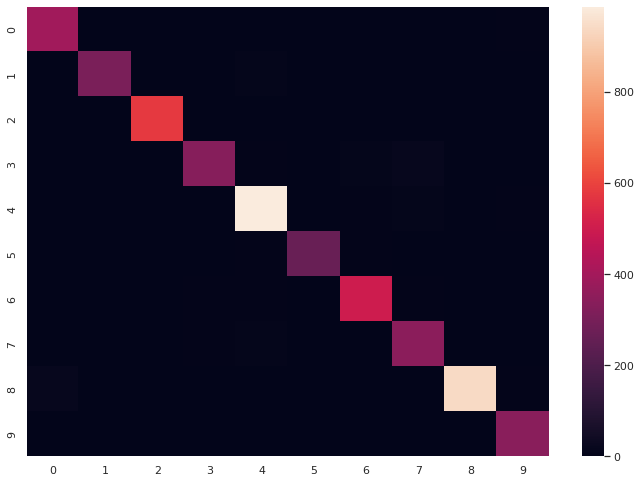

In [32]:
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(mod_fa_mx)
print(mod_fa_mx)

As we can see from the heatmap, we can say our model is working pretty well and the heatmap failed to visualize the confusion matrix. The false amount of false classifications is relatively low, we can say our network is running well.

In [34]:
print('Accuracy of the "model": {:.2f}%'.format(np.mean(mod_mx.diagonal()/mod_mx.sum(axis=1) * 100)))
print('Accuracy of the "model_ft_all": {:.2f}%'.format(np.mean(mod_fa_mx.diagonal()/mod_fa_mx.sum(axis=1) * 100)))


Accuracy of the "model": 93.84%
Accuracy of the "model_ft_all": 95.85%
